In [1]:
import os
import pandas as pd
import openai
import numpy as np
from tqdm import tqdm
from dotenv import load_dotenv
import tiktoken
import ast
import json
from langchain_core.output_parsers import JsonOutputParser # Still useful for get_format_instructions if needed elsewhere
import concurrent.futures
import matplotlib.pyplot as plt
import logging

load_dotenv()
openai.api_key = os.environ['OPENAI_API_KEY']

In [2]:
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.StreamHandler(), # 輸出到控制台
        # logging.FileHandler("llm_qa.log") # 如果需要輸出到檔案
    ],
)

In [3]:
excel_path = "data/tcfd第四層揭露指引.xlsx"
df_labels = pd.read_excel(excel_path, sheet_name='工作表2').dropna(subset=['Label', 'Definition'])
label_mapping = dict(zip(df_labels['Label'], df_labels['Definition']))

In [4]:
label_mapping

{'G-1-1_1': '公司是否描述向董事會和/或董事會下設委員會，定期報告氣候相關風險與機會之流程？',
 'G-1-1_2': '公司是否描述向董事會和/或董事會下設委員會，報告氣候相關風險與機會之頻率？',
 'G-1-2_3': '公司是否描述董事會和/或董事會下設委員會，在監督和指導策略、重要行動計畫、風險管理政策、年度預算和營業計畫、公司的營業目標、計畫實施和執行情況時，考量氣候相關風險與機會？',
 'G-1-2_4': '公司是否描述董事會和/或董事會下設委員會，在監督重要資本支出、企業收購和撤資時，考量氣候相關風險與機會？',
 'G-1-3_5': '公司是否描述董事會或其所屬和/或指派之委員會如何監督風險與機會目標之實現？',
 'G-2-1_6': '公司是否描述已分派氣候相關責任給管理職位或委員會？',
 'G-2-1_7': '公司是否描述該管理職位或委員會向董事會或董事會下設委員會進行報告？',
 'G-2-1_8': '公司是否描述已分派之職責包含評估和/或管理氣候相關風險與機會？',
 'G-2-2_9': '公司是否有對氣候相關組織結構之描述？',
 'G-2-2_10': '公司是否描述有跨部門之氣候相關工作小組統籌執行相關工作？',
 'G-2-3_11': '公司是否描述執行管理階層掌握氣候相關風險與機會之流程？',
 'G-2-4_12': '公司是否提供管理階層透過特定職位監控氣候相關風險與機會之說明？',
 'G-2-4_13': '公司是否提供管理階層透過委員會監控氣候相關風險與機會之說明？',
 'S-1-1_14': '公司是否描述「短期」的氣候相關風險與機會，並考量其資產或基礎設施的使用壽命？',
 'S-1-1_15': '公司是否描述「中期」的氣候相關風險與機會，並考量其資產或基礎設施的使用壽命，以及中期對公司與供應鏈潛在的氣候相關風險與機會？',
 'S-1-1_16': '公司是否描述「長期」的氣候相關風險與機會，並考量其資產或基礎設施的使用壽命，以及長期對公司與供應鏈潛在的氣候相關風險與機會？',
 'S-1-2_17': '公司應描述在「短期」的時間長度下，可能會產生重大財務影響的氣候相關風險與機會？',
 'S-1-2_18': '公司應描述在「中期」的時間長度下，可能會產生重大財務影響的氣候相

In [ ]:
MODEL_NAME = "gpt-4o-mini"
tokenizer = tiktoken.encoding_for_model(MODEL_NAME)

def query_llm_for_verification(chunk, matched_label_json):

    prompt = f"""
        ### 核心指令：極度重要，請務必嚴格遵守 ###
        你必須像一位極其精確且嚴謹的氣候相關財務揭露 (TCFD) 專家，負責審閱報告內容並進行**絕對精確**的標籤分類判斷。你的回覆必須嚴格遵循所有指令，特別是關於「label」欄位的值。

        ### 角色與背景 ###
        你對 Task Force on Climate-related Financial Disclosures (TCFD) 第四層揭露指引及其詳細定義有深入的理解。

        ### 報告書內容 ###
        請仔細審閱以下報告書片段：
        {chunk}

        ### 評估目標 ###
        你的任務是針對「請評估的揭露標準列表」中**提供的每個揭露標準及其明確定義**進行評估。你的判斷必須**嚴格依據**上述「報告書內容」以及「每個標準所提供的定義」。

        **重要限制：**
        * **絕對不要評估或包含任何不在「請評估的揭露標準列表」中提供的標準。**
        * **你的回覆中，`label` 欄位的值必須直接且精確地從提供的列表中複製，不得有任何修改或變體。**

        **請評估的揭露標準列表 (包含標籤代碼和其定義，請逐一評估此列表中的每個標準):**
        {matched_label_json}

        ### 輸出格式：嚴格純 JSON 陣列 ###
        你的回覆必須是**完全純粹的 JSON 格式陣列**，**不包含任何 Markdown 語法（例如 ```json` `）、程式碼區塊、任何額外說明文字、引言、開場白或結尾語。**
        * **JSON 陣列中的物件數量必須與「請評估的揭露標準列表」中提供的標準數量完全一致。**

        每個 JSON 物件必須包含以下四個欄位：
        1.  **chunk**: string。此欄位必須**直接複製**原始輸入的報告書內容片段，即 `{chunk}` 的**完整內容**。
        2.  **label**: string。此欄位的值**必須且只能**從上方「請評估的揭露標準列表」中提供的**確切 `label` 代碼**中選擇。**絕不允許生成任何不在該列表中的 `label` 代碼、變體或任何新的標籤。**
        3.  **reason**: string。請詳細說明你判斷是否有接露此揭露標準的完整推理過程。
        4.  **is_disclosed**: boolean。若報告書中**明確且充分地**揭露了該標準的定義，則回覆 1 (true)；若**未明確揭露**或內容不符合定義，則回覆 0 (false)。

        **範例回覆結構 (請根據實際評估結果，生成符合此格式的完整 JSON 陣列內容，不要包含此範例的文字說明):**
        ```json
        [{{
            "chunk": "（此處為報告書片段的完整內容）",
            "label": "G-1-1_1",
            "reason": "報告書中提到「董事會定期審閱氣候風險報告」，明確符合該標準定義。",
            "is_disclosed": true
        }},
        {{
            "chunk": "（此處為報告書片段的完整內容）",
            "label": "G-1-1_2",
            "reason": "報告書中未具體說明向董事會報告氣候相關風險與機會的頻率。",
            "is_disclosed": false
        }}]
    """

    try:
        response = openai.chat.completions.create(
            model=MODEL_NAME,
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        return response.choices[0].message.content.strip()
    except openai.APIError as e: # 更精確地捕獲 OpenAI API 錯誤
        print(f"OpenAI API Error querying LLM: {e}")
        return "Error: OpenAI API Error"
    except Exception as e:
        print(f"Unexpected error querying LLM: {e}")
        return "Error: Unexpected LLM Query Error"

In [61]:
similarity_matched_dir = "data/tcfd_report_pdf_chunks_matching_result_第四層/"
chunk_csv_files = [os.path.join(similarity_matched_dir, f) for f in os.listdir(similarity_matched_dir) if f.endswith('.csv')]
df_chunks_all = pd.concat([pd.read_csv(file) for file in chunk_csv_files], ignore_index=True)

In [62]:
df_chunks_all

,Filename,Chunk_ID,Chunk_Text,Original_Embedding_Str,Matched_Categories_List,Matched_Distances_List
0,上海商銀_2022.pdf,0,2022 年氣候相關財務揭露TCFD 報告書 \n \n-4-\n1 \n治理 \n1.1 ...,"[-0.0016959677450358868, -0.029846400022506714...","['MT-1-6_#MT1', 'G-1-1_1', 'G-1-2_3', 'G-1-1_2...","[0.25180827119496446, 0.2552670243581123, 0.25..."
1,上海商銀_2022.pdf,1,會，其中由風險管理處主導的環境永續小組，負責評估氣候變遷相關的風險、提出應對策略、推動氣候行...,"[0.004301038105040789, -0.02905302494764328, -...","['G-1-1_1', 'G-1-2_3', 'G-2-4_13', 'G-1-1_2', ...","[0.21927941434940848, 0.22110346495374572, 0.2..."
2,上海商銀_2022.pdf,2,檢視本行氣候行動目標與績效 \n執行關於環境、社會、治理ESG 目標向董事\n會報告氣候策略...,"[-0.010988457128405571, -0.0209538284689188, 0...","['G-1-2_3', 'G-1-1_1', 'MT-1-6_#MT1', 'S-2-5_3...","[0.23832662958047346, 0.25395782676716977, 0.2..."
3,上海商銀_2022.pdf,3,-5-\n風險管理委員會 \n風險管理委員會由董事及獨立董事等成員組成，秉於董事會授權，以善...,"[-0.006103315856307745, -0.014614122919738293,...","['G-1-2_3', 'G-1-1_1', 'G-2-4_13', 'G-1-1_2', ...","[0.24406465956248338, 0.24860720823953583, 0.2..."
4,上海商銀_2022.pdf,4,措施。 \n工作小組 \n工作職掌 \n永續發展委員會 \n負責審議氣候相關議題之策略、風險...,"[-0.022168325260281563, -0.021073754876852036,...","['G-1-2_3', 'G-2-2_10', 'G-1-3_5', 'G-1-1_1', ...","[0.26458226221723735, 0.26901224917648386, 0.2..."
...,...,...,...,...,...,...
122,上海商銀_2022.pdf,122,現況 \n中長期規劃與行動 \n能源使用 \n再生能源使用量 \n再生能源憑證（張） \n3...,"[0.006506481673568487, -0.03163726627826691, 0...","['MT-1-7_#MT2', 'S-1-2_18', 'MT-1-1_58', 'MT-1...","[0.2700649220478804, 0.2823034139386725, 0.283..."
123,上海商銀_2022.pdf,123,53.28 \n持續推動太陽光電貸款，並增加綠能 ESG 相關產\n業放款 \n永續連結貸款...,"[-0.0024616613518446684, -0.036334387958049774...","['MT-1-7_#MT2', 'MT-1-6_#MT1', 'MT-1-5_66', 'S...","[0.25527692665705354, 0.29635673999553097, 0.2..."
124,上海商銀_2022.pdf,124,-50-\n未來展望 \n近年來，全球氣候變遷所帶來的影響日益嚴重，不僅對環境和生態系統構成...,"[-0.012522588483989239, -0.02736271172761917, ...","['MT-1-7_#MT2', 'S-2-5_35', 'S-1-2_19', 'R-2-1...","[0.2478190164369914, 0.25457629756015393, 0.25..."
125,上海商銀_2022.pdf,125,目標設定，並逐步透過議合、加大投融資低碳轉型相關供應鏈產業等方式，還將逐步協助融資客戶和投資...,"[-0.011230221949517727, -0.044161733239889145,...","['S-2-6_37', 'MT-1-7_#MT2', 'MT-3-1_75', 'MT-1...","[0.27956716184469355, 0.2877571487755839, 0.28..."


In [63]:
def convert_to_list(x):
    if isinstance(x, list):
        return x
    elif isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception as e:
            print("轉換錯誤：", e)
            return []
    else:
        return []

all_labels_lists = df_chunks_all['Matched_Categories_List'].apply(convert_to_list)

# 將所有列表攤平成一個大列表
unique_labels = set()
for labels in all_labels_lists:
    unique_labels.update(labels)

print("所有欄位的 Matched_Categories 中共有", len(unique_labels), "個 unique 的 label")
print("Unique labels:", unique_labels)

所有欄位的 Matched_Categories 中共有 88 個 unique 的 label
Unique labels: {'S-1-3_20', 'G-2-1_8', 'G-1-2_3', 'S-1-1_14', 'S-3-2_40', 'MT-3-3_81', 'S-2-6_36', 'MT-1-8_#MT3', 'S-2-3_32', 'R-3-1_55', 'MT-1-6_#MT1', 'R-1-3_49', 'G-1-1_2', 'R-1-1_47', 'MT-3-2_76', 'S-1-2_17', 'MT-2-3_71', 'G-2-2_10', 'MT-1-1_59', 'S-2-5_35', 'G-2-4_13', 'S-3-2_43', 'S-2-2_28', 'MT-3-2_79', 'MT-2-1_67', 'S-2-4_33', 'S-3-2_41', 'MT-1-2_60', 'S-2-2_31', 'S-1-2_19', 'S-2-2_30', 'S-1-5_#S1', 'MT-2-4_#MT5', 'MT-1-1_57', 'S-1-2_18', 'R-2-3_54', 'R-2-2_53', 'S-3-1_38', 'S-1-4_22', 'S-2-1_24', 'MT-3-3_80', 'S-1-1_16', 'S-2-1_25', 'MT-1-3_62', 'MT-3-4_82', 'S-2-1_26', 'MT-3-1_74', 'R-1-3_50', 'MT-1-7_#MT2', 'R-1-5_#R2', 'MT-1-4_64', 'MT-2-2_70', 'G-1-2_4', 'R-1-1_46', 'R-1-2_48', 'R-3-2_56', 'MT-2-3_72', 'G-2-4_12', 'S-2-1_23', 'MT-1-8_#MT4', 'S-2-6_37', 'R-2-1_51', 'S-1-4_21', 'S-3-3_44', 'MT-2-1_68', 'G-1-3_5', 'R-1-4_#R1', 'G-1-1_1', 'S-1-5_#S2', 'G-2-1_6', 'MT-2-3_73', 'S-1-1_15', 'MT-1-2_61', 'MT-3-2_78', 'G-2-1_7', 'S-3-

In [64]:
def transform_matched_categories(val):
    # 若欄位為空值，則回傳空清單的JSON字串
    if pd.isnull(val):
        return json.dumps([])
    try:
        label_list = ast.literal_eval(val) if isinstance(val, str) else val
    except Exception as e:
        label_list = []
    
    json_list = []
    for label in label_list:
        json_list.append({
            "label": label,
            "label_definition": label_mapping.get(label, "")
        })
    return json.dumps(json_list, ensure_ascii=False)


In [65]:
df_chunks_all['Matched_Categories'] = df_chunks_all['Matched_Categories_List'].apply(transform_matched_categories)

df_chunks_all.head()

,Filename,Chunk_ID,Chunk_Text,Original_Embedding_Str,Matched_Categories_List,Matched_Distances_List,Matched_Categories
0,上海商銀_2022.pdf,0,2022 年氣候相關財務揭露TCFD 報告書 \n \n-4-\n1 \n治理 \n1.1 ...,"[-0.0016959677450358868, -0.029846400022506714...","['MT-1-6_#MT1', 'G-1-1_1', 'G-1-2_3', 'G-1-1_2...","[0.25180827119496446, 0.2552670243581123, 0.25...","[{""label"": ""MT-1-6_#MT1"", ""label_definition"": ..."
1,上海商銀_2022.pdf,1,會，其中由風險管理處主導的環境永續小組，負責評估氣候變遷相關的風險、提出應對策略、推動氣候行...,"[0.004301038105040789, -0.02905302494764328, -...","['G-1-1_1', 'G-1-2_3', 'G-2-4_13', 'G-1-1_2', ...","[0.21927941434940848, 0.22110346495374572, 0.2...","[{""label"": ""G-1-1_1"", ""label_definition"": ""公司是..."
2,上海商銀_2022.pdf,2,檢視本行氣候行動目標與績效 \n執行關於環境、社會、治理ESG 目標向董事\n會報告氣候策略...,"[-0.010988457128405571, -0.0209538284689188, 0...","['G-1-2_3', 'G-1-1_1', 'MT-1-6_#MT1', 'S-2-5_3...","[0.23832662958047346, 0.25395782676716977, 0.2...","[{""label"": ""G-1-2_3"", ""label_definition"": ""公司是..."
3,上海商銀_2022.pdf,3,-5-\n風險管理委員會 \n風險管理委員會由董事及獨立董事等成員組成，秉於董事會授權，以善...,"[-0.006103315856307745, -0.014614122919738293,...","['G-1-2_3', 'G-1-1_1', 'G-2-4_13', 'G-1-1_2', ...","[0.24406465956248338, 0.24860720823953583, 0.2...","[{""label"": ""G-1-2_3"", ""label_definition"": ""公司是..."
4,上海商銀_2022.pdf,4,措施。 \n工作小組 \n工作職掌 \n永續發展委員會 \n負責審議氣候相關議題之策略、風險...,"[-0.022168325260281563, -0.021073754876852036,...","['G-1-2_3', 'G-2-2_10', 'G-1-3_5', 'G-1-1_1', ...","[0.26458226221723735, 0.26901224917648386, 0.2...","[{""label"": ""G-1-2_3"", ""label_definition"": ""公司是..."


In [66]:
json_parser = JsonOutputParser()
format_instructions = json_parser.get_format_instructions()
print(format_instructions)

Return a JSON object.


In [67]:
def process_row(index, row):
    chunk_text = row['Chunk_Text']
    matched_categories_json = row['Matched_Categories']
    logging.info(f"處理第 {index} 筆資料...")
    
    # Directly call the function; no need for json_parser.invoke()
    response = query_llm_for_verification(chunk_text, matched_categories_json)
    
    return index, response

In [68]:
results = {}

with concurrent.futures.ThreadPoolExecutor(max_workers=15) as executor:
    future_to_index = {executor.submit(process_row, index, row): index for index, row in df_chunks_all.iterrows()}
    for future in concurrent.futures.as_completed(future_to_index):
        index = future_to_index[future]
        try:
            idx, response = future.result()
            results[idx] = response
        except Exception as exc:
            print(f"第 {index} 筆資料處理發生異常: {exc}")
            results[index] = "Error during concurrent processing"

df_chunks_all['LLM_Response'] = df_chunks_all.index.map(results.get)

print(df_chunks_all[['Chunk_Text', 'Matched_Categories', 'LLM_Response']].head())

2025-06-07 23:47:51,665 - INFO - 處理第 0 筆資料...
2025-06-07 23:47:51,668 - INFO - 處理第 1 筆資料...
2025-06-07 23:47:51,676 - INFO - 處理第 2 筆資料...
2025-06-07 23:47:51,677 - INFO - 處理第 3 筆資料...
2025-06-07 23:47:51,679 - INFO - 處理第 4 筆資料...
2025-06-07 23:47:51,685 - INFO - 處理第 5 筆資料...
2025-06-07 23:47:51,692 - INFO - 處理第 6 筆資料...
2025-06-07 23:47:51,696 - INFO - 處理第 7 筆資料...
2025-06-07 23:47:51,699 - INFO - 處理第 8 筆資料...
2025-06-07 23:47:51,703 - INFO - 處理第 9 筆資料...
2025-06-07 23:47:51,707 - INFO - 處理第 10 筆資料...


2025-06-07 23:47:51,713 - INFO - 處理第 11 筆資料...
2025-06-07 23:47:51,714 - INFO - 處理第 12 筆資料...
2025-06-07 23:47:51,718 - INFO - 處理第 13 筆資料...
2025-06-07 23:47:51,721 - INFO - 處理第 14 筆資料...
2025-06-07 23:48:57,306 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-07 23:48:57,309 - INFO - 處理第 15 筆資料...
2025-06-07 23:49:22,856 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-07 23:49:23,043 - INFO - 處理第 16 筆資料...
2025-06-07 23:49:23,513 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-07 23:49:23,515 - INFO - 處理第 17 筆資料...
2025-06-07 23:49:28,279 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-07 23:49:28,459 - INFO - 處理第 18 筆資料...
2025-06-07 23:49:30,362 - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-06-07 23:49:30,467 - INFO - 處理第 19 筆資料...
2025-06-07 2

                                          Chunk_Text  \
0  2022 年氣候相關財務揭露TCFD 報告書 \n \n-4-\n1 \n治理 \n1.1 ...   
1  會，其中由風險管理處主導的環境永續小組，負責評估氣候變遷相關的風險、提出應對策略、推動氣候行...   
2  檢視本行氣候行動目標與績效 \n執行關於環境、社會、治理ESG 目標向董事\n會報告氣候策略...   
3  -5-\n風險管理委員會 \n風險管理委員會由董事及獨立董事等成員組成，秉於董事會授權，以善...   
4  措施。 \n工作小組 \n工作職掌 \n永續發展委員會 \n負責審議氣候相關議題之策略、風險...   

                                  Matched_Categories  \
0  [{"label": "MT-1-6_#MT1", "label_definition": ...   
1  [{"label": "G-1-1_1", "label_definition": "公司是...   
2  [{"label": "G-1-2_3", "label_definition": "公司是...   
3  [{"label": "G-1-2_3", "label_definition": "公司是...   
4  [{"label": "G-1-2_3", "label_definition": "公司是...   

                                        LLM_Response  
0  [{\n    "chunk": "2022 年氣候相關財務揭露TCFD 報告書 \n\n-...  
1  [{\n    "chunk": "會，其中由風險管理處主導的環境永續小組，負責評估氣候變遷...  
2  [{\n    "chunk": "檢視本行氣候行動目標與績效 \n執行關於環境、社會、治理...  
3  [{\n    "chunk": "-5-\n風險管理委員會 \n風險管理委員會由董事及獨立...  
4  [{\n    "chunk": "措施。 \n工作小組 \n工作職掌 \n永續發展委員會 ..

In [69]:
def analyze_llm_responses(df):
    all_original_labels = set()
    all_llm_found_labels = set()

    for _, row in df.iterrows():
        try:
            # Get original matched categories
            original_matched = json.loads(row['Matched_Categories'])
            original_labels = {item['label'] for item in original_matched}
            all_original_labels.update(original_labels)

            # Get LLM identified labels
            llm_response = row['LLM_Response']
            if llm_response.startswith("Error"): # 檢查是否為之前設定的錯誤標記
                logging.warning(f"Skipping row {row.name} due to LLM response error: {llm_response}")
                continue

            llm_parsed_response = json.loads(llm_response)
            llm_labels = {item['label'] for item in llm_parsed_response}
            all_llm_found_labels.update(llm_labels)

        except json.JSONDecodeError as e:
            logging.error(f"Error parsing LLM_Response for row {row.name}: {e} - Response: {row['LLM_Response'][:200]}...") # 記錄錯誤和部分響應
            continue
        except Exception as e:
            logging.error(f"Unexpected error in analyze_llm_responses for row {row.name}: {e}")
            continue
    
    # Labels found by LLM but not in original matches
    new_labels = all_llm_found_labels - all_original_labels
    
    print(f"Original matched labels: {len(all_original_labels)}")
    print(f"Labels identified by LLM: {len(all_llm_found_labels)}")
    print(f"New labels found by LLM: {len(new_labels)}")
    print(new_labels)
    
    return new_labels

In [70]:
df_chunks_all.to_csv("data/llm_question_answering_results/tcfd_report_pdf_chunks_matching_result_第四層_with_llm_response.csv", index=False, encoding='utf-8')

In [25]:
verified_df = pd.read_csv('data/llm_question_answering_results/tcfd_report_pdf_chunks_matching_result_第四層_with_llm_response.csv')

# verified_df.head(20).to_csv("data/llm_question_answering_results/tcfd_report_pdf_chunks_matching_result_第四層_with_llm_response_shorter.csv", index=False, encoding='utf-8')

In [26]:
verified_df.head()

,Filename,Chunk_ID,Chunk_Text,Original_Embedding_Str,Matched_Categories_List,Matched_Distances_List,Matched_Categories,LLM_Response,Valid_JSON
0,上海商銀_2022.pdf,0,2022 年氣候相關財務揭露TCFD 報告書 \n \n-4-\n1 \n治理 \n1.1 ...,"[-0.0016959677450358868, -0.029846400022506714...","['MT-1-6_#MT1', 'G-1-1_1', 'G-1-2_3', 'G-1-1_2...","[0.2521331408730023, 0.2553625437134743, 0.256...","[{""label"": ""MT-1-6_#MT1"", ""label_definition"": ...","[\n {\n ""label"": ""MT-1-6_#MT1"",\n ""reas...",True
1,上海商銀_2022.pdf,1,會，其中由風險管理處主導的環境永續小組，負責評估氣候變遷相關的風險、提出應對策略、推動氣候行...,"[0.004301038105040789, -0.02905302494764328, -...","['G-1-1_1', 'G-1-2_3', 'G-2-4_13', 'G-1-1_2', ...","[0.21944625854696198, 0.22117471674538133, 0.2...","[{""label"": ""G-1-1_1"", ""label_definition"": ""公司是...","[\n {\n ""label"": ""G-1-1_1"",\n ""reason"":...",True
2,上海商銀_2022.pdf,2,檢視本行氣候行動目標與績效 \n執行關於環境、社會、治理ESG 目標向董事\n會報告氣候策略...,"[-0.010988457128405571, -0.0209538284689188, 0...","['G-1-2_3', 'G-1-1_1', 'MT-1-6_#MT1', 'S-2-5_3...","[0.23836957539772363, 0.25408120777229853, 0.2...","[{""label"": ""G-1-2_3"", ""label_definition"": ""公司是...","[\n {\n ""label"": ""G-1-2_3"",\n ""reason"":...",True
3,上海商銀_2022.pdf,3,-5-\n風險管理委員會 \n風險管理委員會由董事及獨立董事等成員組成，秉於董事會授權，以善...,"[-0.006103315856307745, -0.014614122919738293,...","['G-1-2_3', 'G-1-1_1', 'G-2-4_13', 'G-1-1_2', ...","[0.24421302955816662, 0.24873507937236095, 0.2...","[{""label"": ""G-1-2_3"", ""label_definition"": ""公司是...","[\n {\n ""label"": ""G-1-2_3"",\n ""reason"":...",True
4,上海商銀_2022.pdf,4,措施。 \n工作小組 \n工作職掌 \n永續發展委員會 \n負責審議氣候相關議題之策略、風險...,"[-0.022168325260281563, -0.021073754876852036,...","['G-1-2_3', 'G-2-2_10', 'G-1-3_5', 'G-1-1_1', ...","[0.26462875347793574, 0.2690487559467153, 0.28...","[{""label"": ""G-1-2_3"", ""label_definition"": ""公司是...","[\n {\n ""label"": ""G-1-2_3"",\n ""reason"":...",True


In [27]:
# df = pd.read_csv('data/llm_question_answering_results/tcfd_report_pdf_chunks_matching_result_第四層_with_llm_response_shorter.csv')
def parse_llm_response(response_str):
    if response_str.startswith("```json"):
        response_str = response_str[7:]
    if response_str.endswith("```"):
        response_str = response_str[:-3]
    response_str = response_str.strip()

    try:
        # Use json.loads() to parse the JSON string
        return json.loads(response_str)
    except json.JSONDecodeError as e:
        print(f"JSON 解析失敗: {e}, 原始字串: {response_str[:500]}...") # Print first 500 chars for debugging
        return [] # Return an empty list if parsing fails
    except Exception as e:
        print(f"處理時發生未知錯誤: {e}, 原始字串: {response_str[:500]}...")
        return []

verified_df['llm_list'] = verified_df['LLM_Response'].apply(parse_llm_response)


JSON 解析失敗: Expecting value: line 10 column 21 (char 270), 原始字串: [
  {
    "label": "MT-2-1_67",
    "reason": "報告書明確揭露了範疇一與範疇二的溫室氣體排放量數據，包括年度排放量及排放強度指標，符合該標準要求。",
    "is_disclosed": true
  },
  {
    "label": "S-2-6_37",
    "reason": "報告書提及每百萬營收排放量較上年度減少15.3%，並達成減碳目標，顯示有溫室氣體減量計畫及目標，但未具體描述轉型到低碳經濟的詳細計畫或具體減排活動。",
    "is_disclosed": partially
  },
  {
    "label": "MT-2-1_69",
    "reason": "報告書未明確說明溫室氣體排放量的計算方法是否依據溫室氣體盤查議定書（GHG Protocol），因此無法判斷是否符合該標準。",
    "is_disclosed": false
  },
  {
    "label": "MT-3-1_74",
    "reason": "報告書揭露了與溫室氣體排放相關的目標，如每百萬營收排放量減...


In [28]:
verified_df.head(2)

,Filename,Chunk_ID,Chunk_Text,Original_Embedding_Str,Matched_Categories_List,Matched_Distances_List,Matched_Categories,LLM_Response,Valid_JSON,llm_list
0,上海商銀_2022.pdf,0,2022 年氣候相關財務揭露TCFD 報告書 \n \n-4-\n1 \n治理 \n1.1 ...,"[-0.0016959677450358868, -0.029846400022506714...","['MT-1-6_#MT1', 'G-1-1_1', 'G-1-2_3', 'G-1-1_2...","[0.2521331408730023, 0.2553625437134743, 0.256...","[{""label"": ""MT-1-6_#MT1"", ""label_definition"": ...","[\n {\n ""label"": ""MT-1-6_#MT1"",\n ""reas...",True,"[{'label': 'MT-1-6_#MT1', 'reason': '報告書內容中未提及..."
1,上海商銀_2022.pdf,1,會，其中由風險管理處主導的環境永續小組，負責評估氣候變遷相關的風險、提出應對策略、推動氣候行...,"[0.004301038105040789, -0.02905302494764328, -...","['G-1-1_1', 'G-1-2_3', 'G-2-4_13', 'G-1-1_2', ...","[0.21944625854696198, 0.22117471674538133, 0.2...","[{""label"": ""G-1-1_1"", ""label_definition"": ""公司是...","[\n {\n ""label"": ""G-1-1_1"",\n ""reason"":...",True,"[{'label': 'G-1-1_1', 'reason': '報告書明確提及環境永續小組..."


In [29]:
verified_df_exploded = verified_df.explode('llm_list')

In [30]:
verified_df_exploded.head(2)

,Filename,Chunk_ID,Chunk_Text,Original_Embedding_Str,Matched_Categories_List,Matched_Distances_List,Matched_Categories,LLM_Response,Valid_JSON,llm_list
0,上海商銀_2022.pdf,0,2022 年氣候相關財務揭露TCFD 報告書 \n \n-4-\n1 \n治理 \n1.1 ...,"[-0.0016959677450358868, -0.029846400022506714...","['MT-1-6_#MT1', 'G-1-1_1', 'G-1-2_3', 'G-1-1_2...","[0.2521331408730023, 0.2553625437134743, 0.256...","[{""label"": ""MT-1-6_#MT1"", ""label_definition"": ...","[\n {\n ""label"": ""MT-1-6_#MT1"",\n ""reas...",True,"{'label': 'MT-1-6_#MT1', 'reason': '報告書內容中未提及任..."
0,上海商銀_2022.pdf,0,2022 年氣候相關財務揭露TCFD 報告書 \n \n-4-\n1 \n治理 \n1.1 ...,"[-0.0016959677450358868, -0.029846400022506714...","['MT-1-6_#MT1', 'G-1-1_1', 'G-1-2_3', 'G-1-1_2...","[0.2521331408730023, 0.2553625437134743, 0.256...","[{""label"": ""MT-1-6_#MT1"", ""label_definition"": ...","[\n {\n ""label"": ""MT-1-6_#MT1"",\n ""reas...",True,"{'label': 'G-1-1_1', 'reason': '報告書明確描述董事會作為最高..."


In [31]:
verified_df_exploded['Label'] = verified_df_exploded['llm_list'].apply(lambda x: x.get('label') if isinstance(x, dict) else None)
verified_df_exploded['LLM_Response'] = verified_df_exploded['llm_list'].apply(lambda x: x.get('is_disclosed', 0) if isinstance(x, dict) else 0)

verified_df_final = verified_df_exploded[['Filename', 'Chunk_ID', 'Label', 'LLM_Response']]
verified_df_final

,Filename,Chunk_ID,Label,LLM_Response
0,上海商銀_2022.pdf,0,MT-1-6_#MT1,False
0,上海商銀_2022.pdf,0,G-1-1_1,True
0,上海商銀_2022.pdf,0,G-1-2_3,True
0,上海商銀_2022.pdf,0,G-1-1_2,False
0,上海商銀_2022.pdf,0,G-2-4_13,False
...,...,...,...,...
126,上海商銀_2022.pdf,126,MT-1-2_60,False
126,上海商銀_2022.pdf,126,MT-1-4_64,False
126,上海商銀_2022.pdf,126,MT-1-8_#MT4,False
126,上海商銀_2022.pdf,126,MT-3-2_77,False


In [32]:
unique_label_count = verified_df_final["Label"].nunique()
print("Unique labels count:", unique_label_count)

Unique labels count: 94


In [33]:
import pandas as pd
import ast

# 載入原始的 Label 列表
excel_path = "data/tcfd第四層揭露指引.xlsx"
df_labels = pd.read_excel(excel_path).dropna(subset=['Label', 'Definition'])
original_labels_set = set(df_labels['Label'].unique())
print(f"原始 Excel 文件中唯一 Label 的數量: {len(original_labels_set)}")

# 載入 LLM 處理後的結果 CSV
verified_df = pd.read_csv('data/llm_question_answering_results/tcfd_report_pdf_chunks_matching_result_第四層_with_llm_response.csv')

# 確保 parse_llm_response 能正確處理從 CSV 讀取後的字串（或直接列表）
def parse_llm_response_safe(response_value):
    if isinstance(response_value, list): # 如果它已經是解析過的列表
        return response_value
    elif isinstance(response_value, str):
        try:
            # 檢查是否是錯誤字串
            if response_value.startswith("Error:"):
                return [] # 對於錯誤返回空列表
            return json.loads(response_value)
        except (ValueError, SyntaxError, TypeError) as e:
            # 記錄解析失敗的字串，以便檢查 LLM 輸出是否異常
            print(f"解析 LLM_Response 字串時發生錯誤: {e}, 原始字串: {response_value[:200]}...")
            return []
    return [] # 處理其他非字串也非列表的異常情況

verified_df['llm_list'] = verified_df['LLM_Response'].apply(parse_llm_response_safe)

# 展開 LLM 回應列表並提取 Label
verified_df_exploded = verified_df.explode('llm_list')
# 確保 llm_list 中的元素是字典，並且有 'label' 鍵
verified_df_exploded['Label'] = verified_df_exploded['llm_list'].apply(
    lambda x: x.get('label') if isinstance(x, dict) and 'label' in x else None
)

# 獲取所有由 LLM 處理後產生的唯一 Label
llm_generated_labels_set = set(verified_df_exploded["Label"].dropna().unique())
print(f"LLM 生成的唯一 Label 總數: {len(llm_generated_labels_set)}")

# 找出 LLM 生成但不在原始列表中的 Label
hallucinated_labels = llm_generated_labels_set - original_labels_set

print(f"\nLLM 生成但不在原始 Excel 中的 Label ({len(hallucinated_labels)} 個):")
for label in sorted(list(hallucinated_labels)):
    print(label)

# 可選：將最終數據框只保留在原始 Label 列表中的 Label
verified_df_filtered = verified_df_exploded[
    verified_df_exploded['Label'].isin(original_labels_set)
].copy()
print(f"\n過濾後 LLM 生成的唯一 Label 總數: {verified_df_filtered['Label'].nunique()}")
missing_original_labels = original_labels_set - llm_generated_labels_set
print(f"\n原始 Excel 中存在但在 LLM 處理結果中未出現的 Label ({len(missing_original_labels)} 個):")
for label in sorted(list(missing_original_labels)):
    print(label)

原始 Excel 文件中唯一 Label 的數量: 91
解析 LLM_Response 字串時發生錯誤: Expecting value: line 10 column 21 (char 270), 原始字串: [
  {
    "label": "MT-2-1_67",
    "reason": "報告書明確揭露了範疇一與範疇二的溫室氣體排放量數據，包括年度排放量及排放強度指標，符合該標準要求。",
    "is_disclosed": true
  },
  {
    "label": "S-2-6_37",
    "reason": "報告書提及每百萬營收排放量較上年度減少15.3%，並達...
LLM 生成的唯一 Label 總數: 94

LLM 生成但不在原始 Excel 中的 Label (12 個):
MT-1-6_#MT1
MT-1-7_#MT2
MT-1-8_#MT2
MT-1-8_#MT3
MT-1-8_#MT4
MT-2-4_#MT5
MT-3-1_81
R-1-4_#R1
R-1-5_#R1
R-1-5_#R2
S-1-5_#S1
S-1-5_#S2

過濾後 LLM 生成的唯一 Label 總數: 82

原始 Excel 中存在但在 LLM 處理結果中未出現的 Label (9 個):
#MT-1-6_#MT1
#MT-1-7_#MT2
#MT-1-8_#MT3
#MT-1-8_#MT4
#MT-2-4_#MT5
#R-1-4_#R1
#R-1-5_#R2
#S-1-5_#S1
#S-1-5_#S2


In [34]:
def extract_institution(filename):
    base = filename.split('.')[0]
    institution = base.split('_')[0]
    return institution

def extract_year(filename):
    base = filename.split('.')[0]
    parts = base.split('_')
    if len(parts) > 1:
        return parts[1]
    else:
        return None

def transform_label(label):
    if label is None:
        return None
    if '_' in label:
        return label.split('_')[-1]
    return label

def transform_response(response):
    if response == True or response == 1.0:
        return "Yes"
    elif response == False or response == 0.0:
        return "No"
    else:
        return response

In [35]:
df_transformed = verified_df_final.copy()

df_transformed['Institution'] = df_transformed['Filename'].apply(extract_institution)
df_transformed['Year'] = df_transformed['Filename'].apply(extract_year)

df_transformed['Label'] = df_transformed['Label'].apply(transform_label)

df_transformed['LLM_Response'] = df_transformed['LLM_Response'].apply(transform_response)

df_final = df_transformed[['Institution', 'Year', 'Label', 'LLM_Response']]

In [36]:
df_final["Label"].nunique()

91

In [37]:
df_final.head()

,Institution,Year,Label,LLM_Response
0,上海商銀,2022,#MT1,No
0,上海商銀,2022,1,Yes
0,上海商銀,2022,3,Yes
0,上海商銀,2022,2,No
0,上海商銀,2022,13,No


In [38]:
answer_file_path = "data/answer/rank.xlsx"
answer_df = pd.read_excel(answer_file_path)

answer_df.head(5)

,Symbol,Financial_Institutions,Format,Year,1,2,3,4,5,6,...,R_2,R_3,MT_1,MT_2,MT_3,G,S,R,MT,Disclosure
0,2881,富邦金,1.0,2022,Y,Y,Y,Y,Y,Y,...,0.833333,1.0,0.833333,1.000000,1.00,0.937500,0.972222,0.911111,0.944444,0.941319
1,5880,合庫金,1.0,2022,Y,Y,Y,Y,Y,Y,...,1.000000,1.0,0.541667,1.000000,1.00,1.000000,0.913889,1.000000,0.847222,0.940278
2,5849,永豐銀行,1.0,2022,Y,Y,Y,N,Y,Y,...,1.000000,1.0,0.645833,0.888889,1.00,0.854167,0.975000,0.866667,0.844907,0.885185
3,2891,中信金,1.0,2022,Y,Y,Y,N,Y,Y,...,1.000000,0.5,0.645833,0.888889,0.75,0.916667,0.972222,0.833333,0.761574,0.870949
4,2884,玉山金,1.0,2022,Y,Y,Y,N,Y,Y,...,0.833333,1.0,0.625000,1.000000,0.75,0.916667,0.813889,0.944444,0.791667,0.866667


In [39]:
df_pivot = df_final.pivot_table(index=['Institution', 'Year'], columns='Label', values='LLM_Response', aggfunc='first')
df_pivot.reset_index(inplace=True)
# df_pivot.columns.name = None  # 移除 columns 名稱
# df_pivot.rename(columns={'Institution': 'Financial_Institutions'}, inplace=True)
# df_pivot.fillna("No", inplace=True)
df_pivot.head(5).to_csv("data/llm_question_answering_results/tcfd_report_pdf_chunks_matching_result_第四層_with_llm_response_pivot.csv", index=False, encoding='utf-8')

In [40]:
df_pivot

Label,Institution,Year,#MT1,#MT2,#MT3,#MT4,#MT5,#R1,#R2,#S1,...,75,76,77,78,79,8,80,81,82,9
0,上海商銀,2022,No,No,No,No,No,No,No,No,...,No,No,No,No,No,Yes,No,No,No,Yes


In [41]:
# df_pivot.head(5).to_csv("tcfd_report_pdf_chunks_matching_result_第四層_with_llm_response_pivot_shorter.csv", index=False, encoding='utf-8')

In [42]:
df_pivot.columns = df_pivot.columns.astype(str)
answer_df.columns = answer_df.columns.astype(str)

answer_lookup = {}
for idx, row in answer_df.iterrows():
    key = (str(row['Financial_Institutions']), str(row['Year']))
    answer_lookup[key] = row
id_cols = ['Financial_Institutions', 'Year']

answer_cols_str = [str(x) for x in answer_df.columns]
common_columns = [str(col) for col in df_pivot.columns 
                  if str(col) not in id_cols and str(col) in answer_cols_str]

print("共同比對的欄位：", common_columns)
print(len(common_columns))
correct_count = 0
total_count = 0

inst_results = {}  # 格式：{ institution: {'correct': ..., 'total': ...}, ... }

inst_errors = {}   # 格式：{ institution: [ { 'Year': ..., 'Question': ..., 'Pivot Answer': ..., 'Correct Answer': ... }, ... ] }


for idx, pivot_row in df_pivot.iterrows():
    print(pivot_row)
    institution = str(pivot_row['Institution'])
    if institution[2:4] == "金控":
        institution = institution[0:2] + "金"

    key = (institution, str(pivot_row['Year']))
    if key not in answer_lookup:
        print(f"注意：找不到 {key} 對應於 answer_df 中的資料，跳過 df_pivot 第 {idx} 列。")
        continue
    answer_row = answer_lookup[key]
    print(answer_row)

    if institution not in inst_results:
        inst_results[institution] = {'correct': 0, 'total': 0}
    if institution not in inst_errors:
        inst_errors[institution] = []

    for col in common_columns:
        pivot_val = pivot_row[col]
        if pivot_val == "Yes":
            pivot_mapped = "Y"
        elif pivot_val == "No":
            pivot_mapped = "N"
        else:
            continue

        answer_val = str(answer_row[col])
        if pd.isna(answer_row[col]) or answer_val.lower() == 'nan':
            continue
        
        total_count += 1
        inst_results[institution]['total'] += 1
        
        if pivot_mapped == answer_val:
            correct_count += 1
            inst_results[institution]['correct'] += 1
        else:
            inst_errors[institution].append({
                'Year': pivot_row['Year'],
                'Question': col,
                'Pivot Answer': pivot_mapped,
                'Correct Answer': answer_val
            })

共同比對的欄位： ['#MT1', '#MT2', '#MT3', '#MT4', '#MT5', '#R1', '#R2', '#S1', '#S2', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '8', '80', '81', '82', '9']
91
Label
Institution    上海商銀
Year           2022
#MT1             No
#MT2             No
#MT3             No
               ... 
8               Yes
80               No
81               No
82               No
9               Yes
Name: 0, Length: 93, dtype: object
Symbol                        5876
Financial_Institutions        上海商銀
Format                         1.0
Year                          2022
1                                Y


In [43]:
accuracy = correct_count / total_count if total_count > 0 else np.nan

print("總比對題數：", total_count)
print("正確題數：", correct_count)
print("全體準確率：", accuracy)

總比對題數： 90
正確題數： 35
全體準確率： 0.3888888888888889


In [44]:
print("各家Institution的準確率：")
for inst, counts in inst_results.items():
    inst_accuracy = counts['correct'] / counts['total'] if counts['total'] > 0 else np.nan
    print(f"{inst}: {inst_accuracy}")

各家Institution的準確率：
上海商銀: 0.3888888888888889


In [45]:
print("每家 institution 答錯的題目明細：")
for inst, errors in inst_errors.items():
    if errors:
        print(f"\nInstitution: {inst} Year: {errors[0]['Year']}")
        for err in errors:
            print(f" Question: {err['Question']},  Pivot Answer: {err['Pivot Answer']},  Correct Answer: {err['Correct Answer']}")
    else:
        print(f"\nInstitution: {inst} 沒有答錯的題目。")

每家 institution 答錯的題目明細：

Institution: 上海商銀 Year: 2022
 Question: #MT1,  Pivot Answer: N,  Correct Answer: Y
 Question: #MT5,  Pivot Answer: N,  Correct Answer: Y
 Question: #R1,  Pivot Answer: N,  Correct Answer: Y
 Question: #S1,  Pivot Answer: N,  Correct Answer: Y
 Question: #S2,  Pivot Answer: N,  Correct Answer: Y
 Question: 11,  Pivot Answer: N,  Correct Answer: Y
 Question: 12,  Pivot Answer: N,  Correct Answer: Y
 Question: 13,  Pivot Answer: N,  Correct Answer: Y
 Question: 14,  Pivot Answer: N,  Correct Answer: Y
 Question: 15,  Pivot Answer: N,  Correct Answer: Y
 Question: 17,  Pivot Answer: N,  Correct Answer: Y
 Question: 18,  Pivot Answer: N,  Correct Answer: Y
 Question: 2,  Pivot Answer: N,  Correct Answer: Y
 Question: 20,  Pivot Answer: N,  Correct Answer: Y
 Question: 21,  Pivot Answer: N,  Correct Answer: Y
 Question: 23,  Pivot Answer: N,  Correct Answer: Y
 Question: 24,  Pivot Answer: N,  Correct Answer: Y
 Question: 25,  Pivot Answer: N,  Correct Answer: Y
 Que

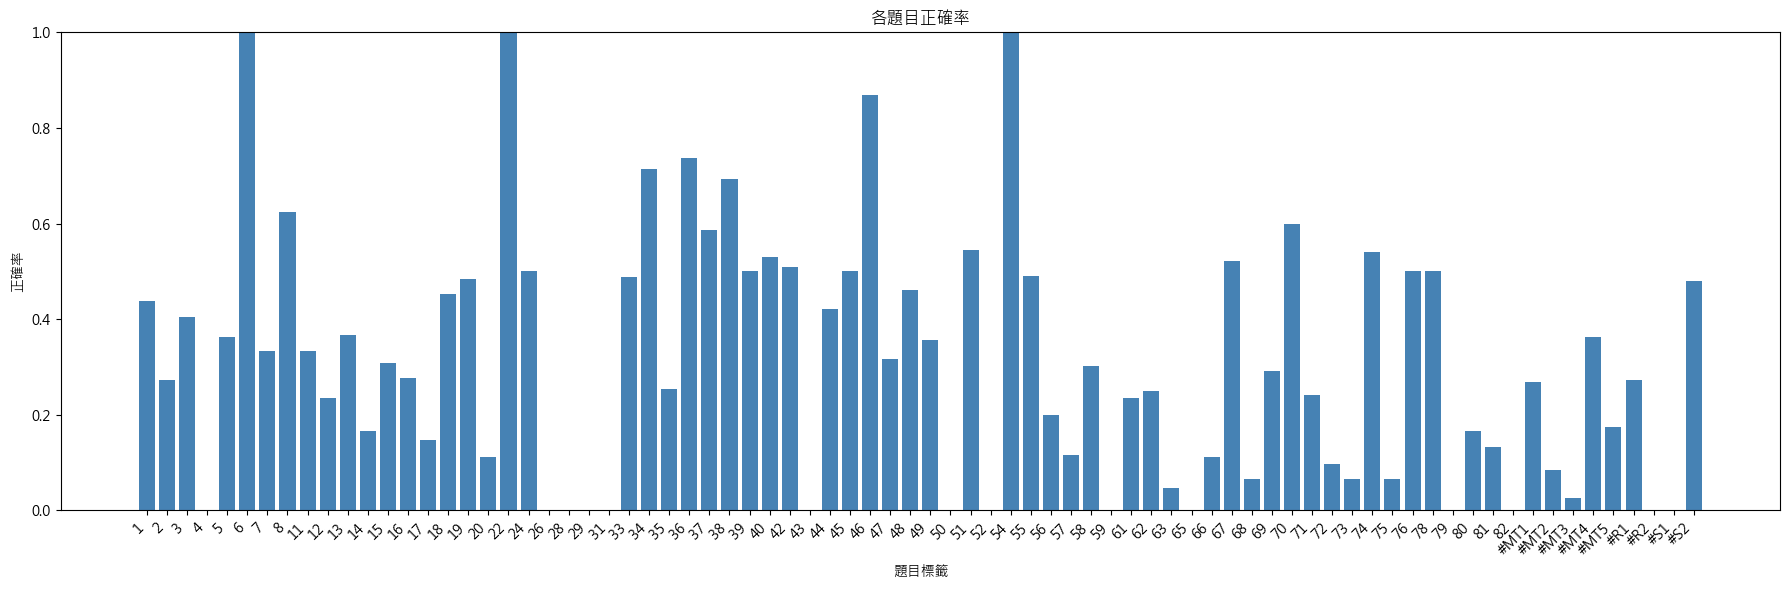

In [24]:
df_correctness = (
    df_final.groupby("Label")["LLM_Response"]
    .apply(lambda x: (x == "Yes").sum() / len(x))
    .reset_index(name="Accuracy")
)

def is_numeric(x):
    try:
        float(x)
        return True
    except ValueError:
        return False

df_correctness["is_numeric"] = df_correctness["Label"].apply(is_numeric)

df_numeric = df_correctness[df_correctness["is_numeric"]].copy()
df_numeric["Label_numeric"] = df_numeric["Label"].astype(float)
df_numeric.sort_values("Label_numeric", inplace=True)

df_text = df_correctness[~df_correctness["is_numeric"]].copy()

df_final_sorted = pd.concat([df_numeric, df_text])

plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(18, 6))
plt.bar(df_final_sorted["Label"], df_final_sorted["Accuracy"], color='steelblue')
plt.xlabel("題目標籤")
plt.ylabel("正確率")
plt.title("各題目正確率")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()